# Анализ бизнес-показателей приложения Procrastinate Pro+

**Описание и цель проекта**

В данном проекте мы будем выполнять роль маркетингового аналитика развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша цель - разобраться в причинах и помочь компании выйти в плюс.

**Описание данных**

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

Нам необходимо ответить на следующие **поставленные вопросы:**

* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

**План работы:**

* загрузка данных и подготовка их к анализу
* загрузка функций для вычисления и анализа LTV, ROI, удержания и конверсии, а также для построения соответствующих им графиков
* исследовательский анализ данных
* анализ расходов на маркетинг
* оценка окупаемости рекламы
* резюмирование и составление рекомендации на основе проведенного анализа

## Загрузка данных и подготовка их к анализу

### Загрузка данных и общая информация

In [1]:
# подключим необходимые библиотеки для работы над проектом
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# загрузим данные
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # визиты
    pd.read_csv('/datasets/orders_info_short.csv'),  # заказы
    pd.read_csv('/datasets/costs_info_short.csv')  # расходы
)

In [3]:
# напишем функцию для выведения общей инфо о датафрейме, пропусках и дубликатах
def information(df):
    return (
        print('\033[1m' + 'Общая информация о данных таблицы:' + '\033[0m'),
        print(df.info()),
        print('\033[1m'+ 'Количество дубликатов:' + '\033[0m'),
        print(df.duplicated().sum()),
        print('\033[1m' + 'Количество пропусков:' + '\033[0m'),
        print(df.isna().sum())
    )

In [4]:
information(visits)

Общая информация о данных таблицы:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
Количество дубликатов:
0
Количество пропусков:
User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64


(None, None, None, None, None, None)

In [5]:
information(orders)

Общая информация о данных таблицы:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
Количество дубликатов:
0
Количество пропусков:
User Id     0
Event Dt    0
Revenue     0
dtype: int64


(None, None, None, None, None, None)

In [6]:
information(costs)

Общая информация о данных таблицы:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
Количество дубликатов:
0
Количество пропусков:
dt         0
Channel    0
costs      0
dtype: int64


(None, None, None, None, None, None)

Итак, по общей информации можно сразу сказать о необходимой предообработке:
* названия столбцов нужно привести к нижнему регистру и заменить пробелы на "змеиный регистр"
* типы данных времени необходимо привести к типу datetime (сейчас они в object)
* gропусков и дубликатов в данных нет

### Предообработка данных

In [7]:
# приведем названия столбцов к нижнему регистру и заменим пробелы на "змеиный регистр"
visits.columns = ['user_id', 'region','device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

In [8]:
# приведем даты во всех датасетах к типу данных datetime, кроме dt в costs - там оставим date
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Итак, по первому шагу выполнена предобработка данных:
* изменены названия столбцов
* все даты приведены к типу данных datetime 
* пропуски и дубликаты не найдены

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии

Создадим функции для вычислений метрик и построения графика.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### Функции для вычисления значений метрик:

In [9]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [10]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [11]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функции для построения графиков:

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [14]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [16]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функции созданы, приступим к анализу.

## Исследовательский анализ данных

**План анализа:**

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

### Составим профили пользователей и определим минимальную и максимальную даты привлечения пользователей

In [17]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5) 

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [18]:
# определим минимальную и максимальную даты привлечения пользователей
profiles['dt'].min()

datetime.date(2019, 5, 1)

In [19]:
profiles['dt'].max()

datetime.date(2019, 10, 27)

Итак, по п. 3.1 составлены профили пользователей со следующими данными:
* уникальные пользователи user_id
* дата первого привлечения в формате datetime first_ts
* канал привлечения channel
* устройство, с которого заходил пользователь device
* страна region
* дата привлечения без времени dt
* месяц привлечения month
* признак платящего/неплатящего пользователя payer
* стоимость привлечения одного пользователя acquisition_cost

Также найдены минимальная и максимальная даты привлечения пользователей: (2019, 5, 1) и (2019, 10, 27), которые соответствуют датам, данным нам в описании проекта. 

### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [20]:
# создадим таблицу с количеством пользователей с разбивкой по странам и посчитаем долю платящих пользователей в каждой стране
region_users = (
    profiles.groupby('region').agg({'user_id': 'nunique'}).reset_index()
    .merge(profiles.query('payer==True').groupby('region').agg({'user_id': 'nunique'}).reset_index(),
          on='region', how='left')
)
region_users.columns = ['region', 'total_users', 'payer_users']
region_users['part_of_payer'] = round(region_users['payer_users'] / region_users['total_users'] *100, 2)
region_users.sort_values(by='part_of_payer', ascending=False)

region  total_users  payer_users  part_of_payer
3  United States       100002         6902           6.90
1        Germany        14981          616           4.11
2             UK        17575          700           3.98
0         France        17450          663           3.80

В следующих заданиях шага 3 требуется посчитать доли и по другим столбцам, поэтому создадим функцию для подсчета долей и создания такой таблицы:

In [21]:
def get_part(column):
    x_users = (
        profiles.groupby(column).agg({'user_id': 'nunique', 'payer': 'mean'}).reset_index()
    )
    x_users.columns = [column, 'total_users', 'payer_part']
    x_users['payer_part'] = round(x_users['payer_part'] * 100, 2)
    return x_users.sort_values(by='payer_part', ascending=False)

In [22]:
region_users = get_part('region')
region_users

region  total_users  payer_part
3  United States       100002        6.90
1        Germany        14981        4.11
2             UK        17575        3.98
0         France        17450        3.80

Итак, по шагу 3.2 мы составили таблицу с количеством и долей платящих пользователей с разбивкой по странам. Самая большая доля платящих пользователей в США (6.9 %), далее идут Германия, Великобритания и Франция с небольшим разбегом долей друг от друга.

### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [23]:
device_users = get_part('device')
device_users

device  total_users  payer_part
1      Mac        30042        6.36
3   iPhone        54479        6.21
0  Android        35032        5.85
2       PC        30455        5.05

Итак, по шагу 3.3 мы составили таблицу с количеством и долей платящих пользователей с разбивкой по устройствам. Самая большая доля платящих пользователей по устройству Mac (6.36 %), немного менее занимает iPnone (6.21 %),  далее Android (5.85 %) и PC (5.05 %).

### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [24]:
channel_users = get_part('channel')
channel_users

channel  total_users  payer_part
1             FaceBoom        29144       12.20
0           AdNonSense         3880       11.34
9       lambdaMediaAds         2149       10.47
6               TipTop        19561        9.60
5       RocketSuperAds         4448        7.91
7       WahooNetBanner         8553        5.30
8              YRabbit         4312        3.83
3         MediaTornado         4364        3.57
2              LeapBob         8553        3.06
4   OppleCreativeMedia         8605        2.71
10             organic        56439        2.06

Итак, по шагу 3.4 мы составили таблицу с количеством и долей платящих пользователей с разбивкой по каналам привлечения. Самая большая доля платящих пользователей пришла из источника FaceBoom (12.2 %), самая малая доля из organic (2.06 %), что логично, т.к. organic - это канал, из которого платящих пользователей мы получаем бесплатно (без рекламы).

## Анализ маркетинга

**План анализа:**

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

### Посчитаем общую сумму расходов на маркетинг.

In [25]:
# посчитаем общую сумму расходов на маркетинг
costs['costs'].sum()

105497.30000000002

### Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [26]:
# создадаим таблицу расходов в разбивке по каналам привлечения
channel_costs = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)
channel_costs

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

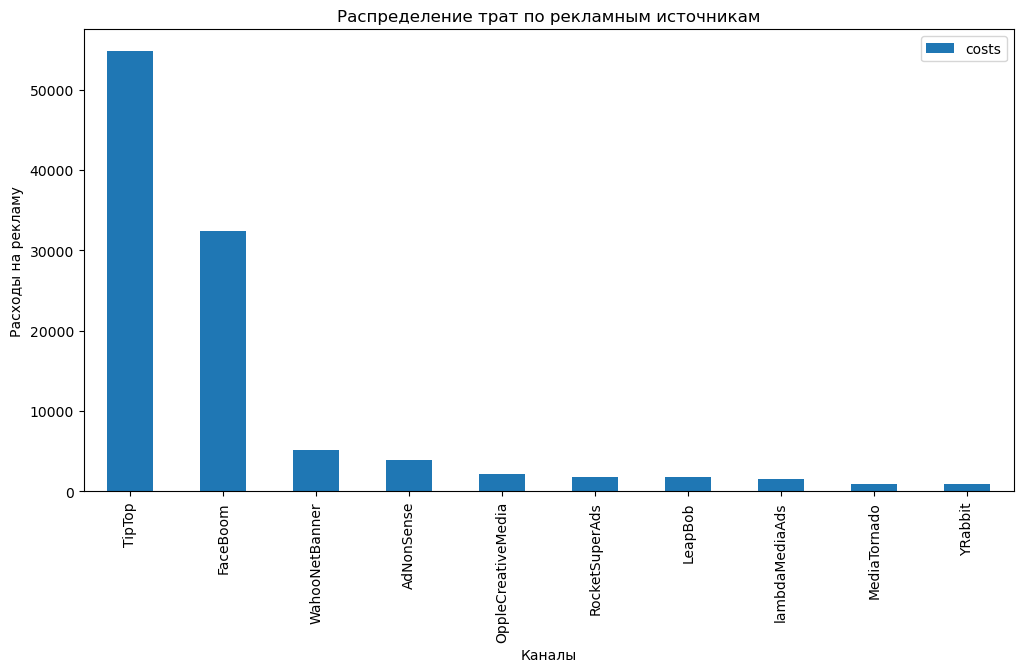

In [27]:
# построим столбчатую диаграмму для визуализации расходов по каналам
channel_costs.plot(kind='bar', figsize=(12,6))
plt.xlabel('Каналы')
plt.ylabel('Расходы на рекламу')
plt.title('Распределение трат по рекламным источникам')
plt.show()

Ого, очень большая часть расходов ушла на канал TipTop - 54751.30. Они в десятки раз превышают расходы на все другие каналы, кроме FaceBoom - на этот канал тоже ушла немалая часть расходов - 32445.60

### Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.

In [28]:
# сначала добавим столбцы с номером недели и месяца для дальнейшей работы
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs

dt         channel  costs  week  month
0     2019-05-01        FaceBoom  113.3    18      5
1     2019-05-02        FaceBoom   78.1    18      5
2     2019-05-03        FaceBoom   85.8    18      5
3     2019-05-04        FaceBoom  136.4    18      5
4     2019-05-05        FaceBoom  122.1    18      5
...          ...             ...    ...   ...    ...
1795  2019-10-23  lambdaMediaAds    4.0    43     10
1796  2019-10-24  lambdaMediaAds    6.4    43     10
1797  2019-10-25  lambdaMediaAds    8.8    43     10
1798  2019-10-26  lambdaMediaAds    8.8    43     10
1799  2019-10-27  lambdaMediaAds   12.0    43     10

[1800 rows x 5 columns]

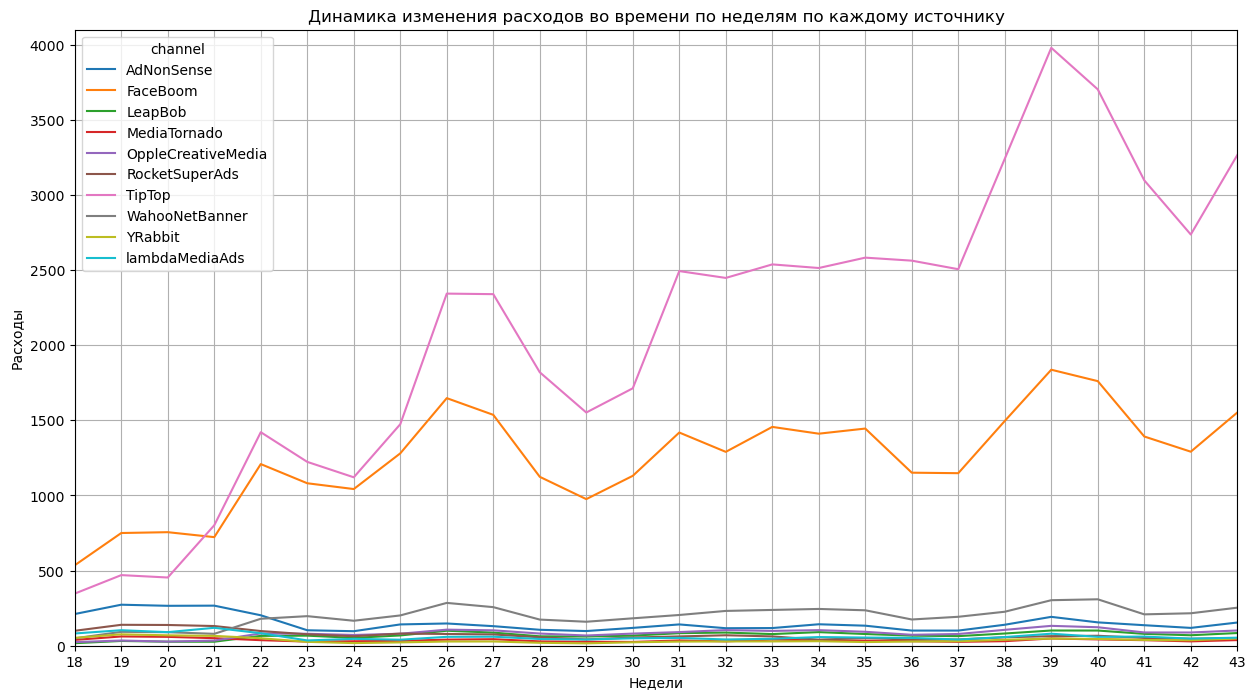

In [29]:
# построим график динамики изменения расходов во времени по неделям по каждому источнику
(
costs
    .pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
    .plot(kind='line', grid=True, figsize=(15,8))
)
plt.xlabel('Недели')
plt.ylabel('Расходы')
plt.xlim(18,43)
plt.ylim(0,4100)
plt.xticks(np.arange(18, 43.1, 1))
plt.title('Динамика изменения расходов во времени по неделям по каждому источнику')
plt.show()

По графику динамики расходов по неделям также видно, что больше всего трат было по каналам TipTop и FaceBoom - они сильно вырываются вверх по сравнению с остальными. Более того, расходы на эти каналы почти постоянно росли, причем в одинаковой динамике (кривые по форме почти совпадают). Также можно отметить 39 неделю с самыми высокими расходами по эти каналам (по другим каналам тоже есть небольшой рост расходов в 39 неделю). На другие каналы изначально выделили небольшой бюджет и от недели к неделе он практически не изменялся.

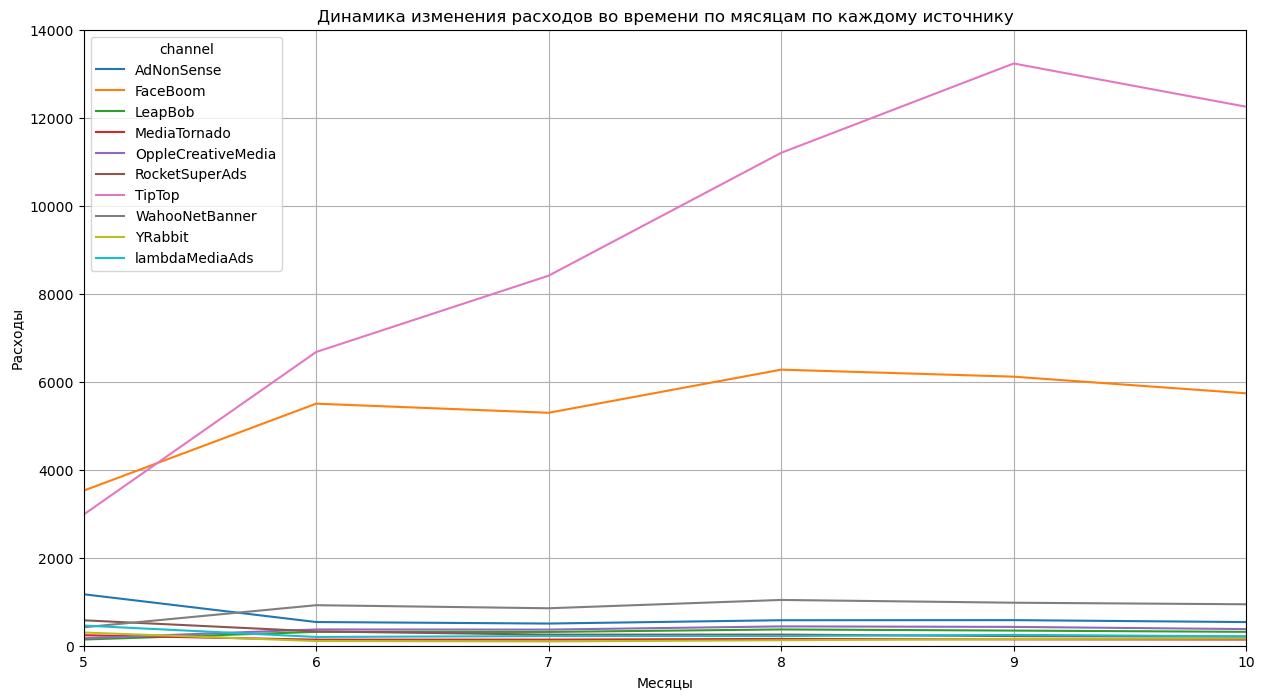

In [30]:
# построим график динамики изменения расходов во времени по месяцам по каждому источнику
(
costs
    .pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
    .plot(kind='line', grid=True, figsize=(15,8))
)
plt.xlabel('Месяцы')
plt.ylabel('Расходы')
plt.xlim(5,10)
plt.ylim(0, 14000)
plt.xticks(np.arange(5, 10.1, 1))
plt.title('Динамика изменения расходов во времени по мясяцам по каждому источнику')
plt.show()

По графику динамики расходов по месяцам также видно, что больше всего трат было по каналам TipTop и FaceBoom - они сильно вырываются вверх по сравнению с остальными. Более того, расходы на канал TipTop постоянно сильно увеличивали вплоть до сентября (было потрачено примерно 13000), в то время как максимальные расходы по каналу FaceBoom составляли чуть больше 6000 (в августе), не говоря уже о расходах в другие каналы - их расходы в несколько раз меньше и практически не менялись от месяца к мясяцу (на уровне 1000 и меньше).

### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

In [31]:
# создадим таблицу с граппировкой по каналам и посчитаем среднюю стоимость привлечения на человека
(
    profiles
    .groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .sort_values(by='acquisition_cost', ascending=False)
)

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000

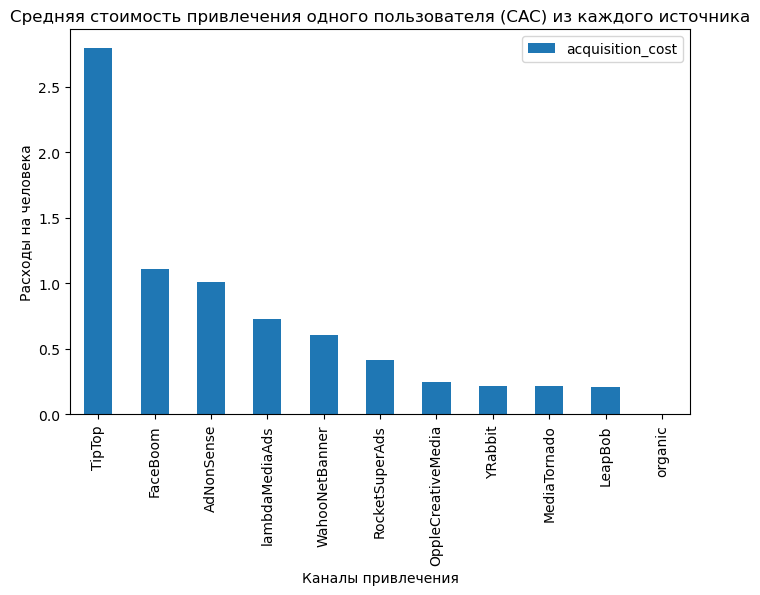

In [32]:
# для визуализации построим столбчатый график
(
    profiles
    .groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .sort_values(by='acquisition_cost', ascending=False)
    .plot(kind='bar', figsize=(8,5))
)
plt.xlabel('Каналы привлечения')
plt.ylabel('Расходы на человека')
plt.title('Средняя стоимость привлечения одного пользователя (CAC) из каждого источника')
plt.show()

Наблюдаем тот же канал привлечения на первом месте по средней стоимости привлечения на человека - TipTop. Далее на втором месте FaceBoom с большим отрывом от TipTop - отличие в расходах больше, чем в два раза. Но также нужно отметить, что другие каналы не так сильно отстают в этом разрезе: снижение расходов на привлечение на 1 человека более менее плавное. Что ж, интересно будет посчитать метрики и выяснить, какие из каналов лучше всего окупили расходы на рекламу и стоил ли таких расходов канал TipTop.

## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Заказчиком дано условие, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определим самостоятельно.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на следующие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

In [33]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

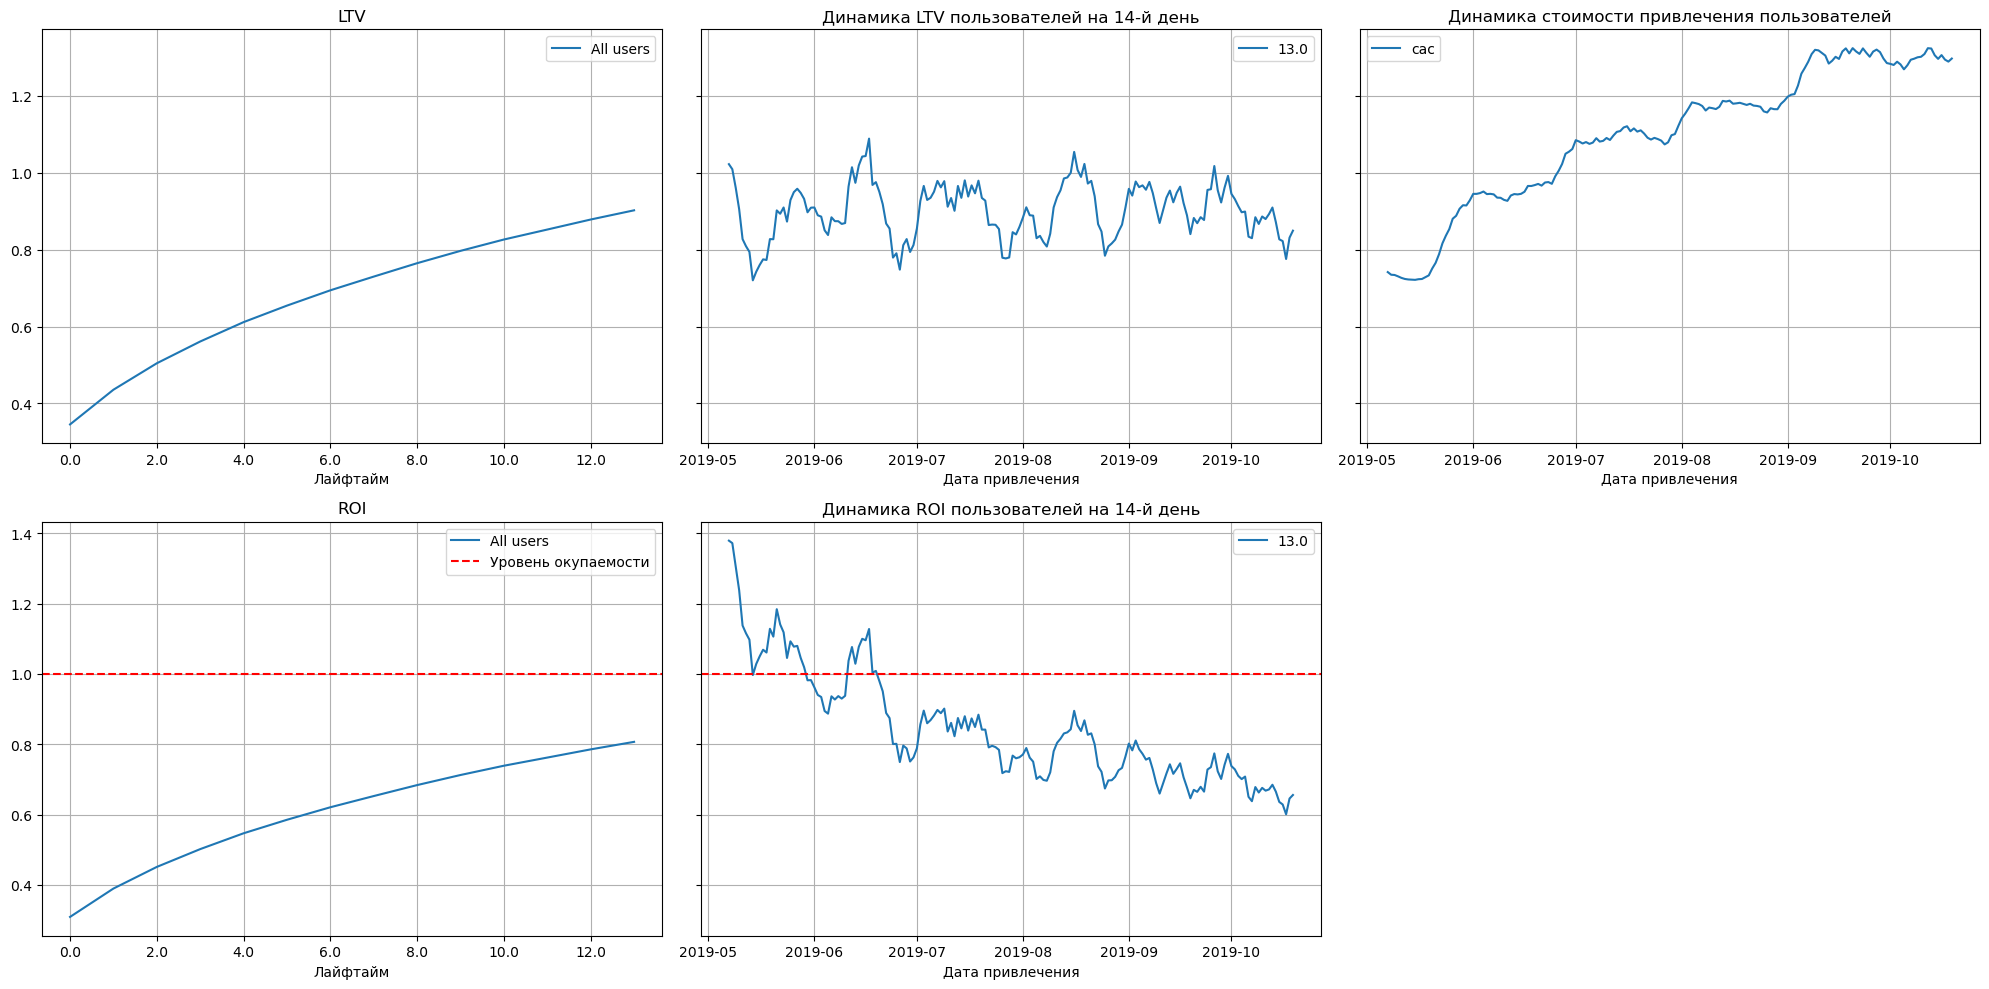

In [34]:
# исключим из анализа органических пользователей, т.к. они достались нам бесплатно
profiles = profiles.query('channel != "organic"')
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:
* Реклама не окупается даже к 14 дню и достигает показателя всего в 80 %. По графику динамики ROI хорошо видно, что реклама окупалась примерно до июня, затем ROI стало опускаться ниже и ниже, пока и вовсе не опустилось ниже уровня окупаемости и опускалось на постоянной основе.
* CAC постоянно увеличивался вплоть до октября, т.е. расходы на рекламу постоянно увеличивали.
* LTV достаточно стабилен, т.е.ухудшения качества пользователей нет.

Чтобы разобраться в причинах убытков компании, позже пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

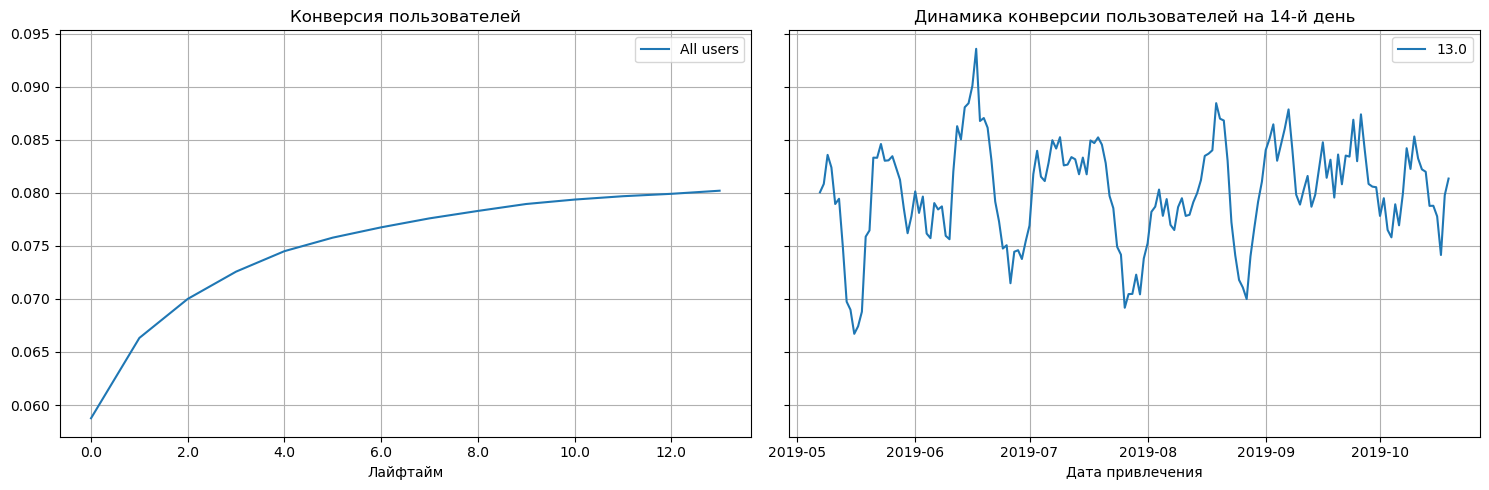

In [35]:
# смотрим общую конверсию пользователей

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

В целом конверсия неплохая и достигает примерно 8 % к 14 дню. Динамика конверсии от мая до июня также была более менее стабильна.

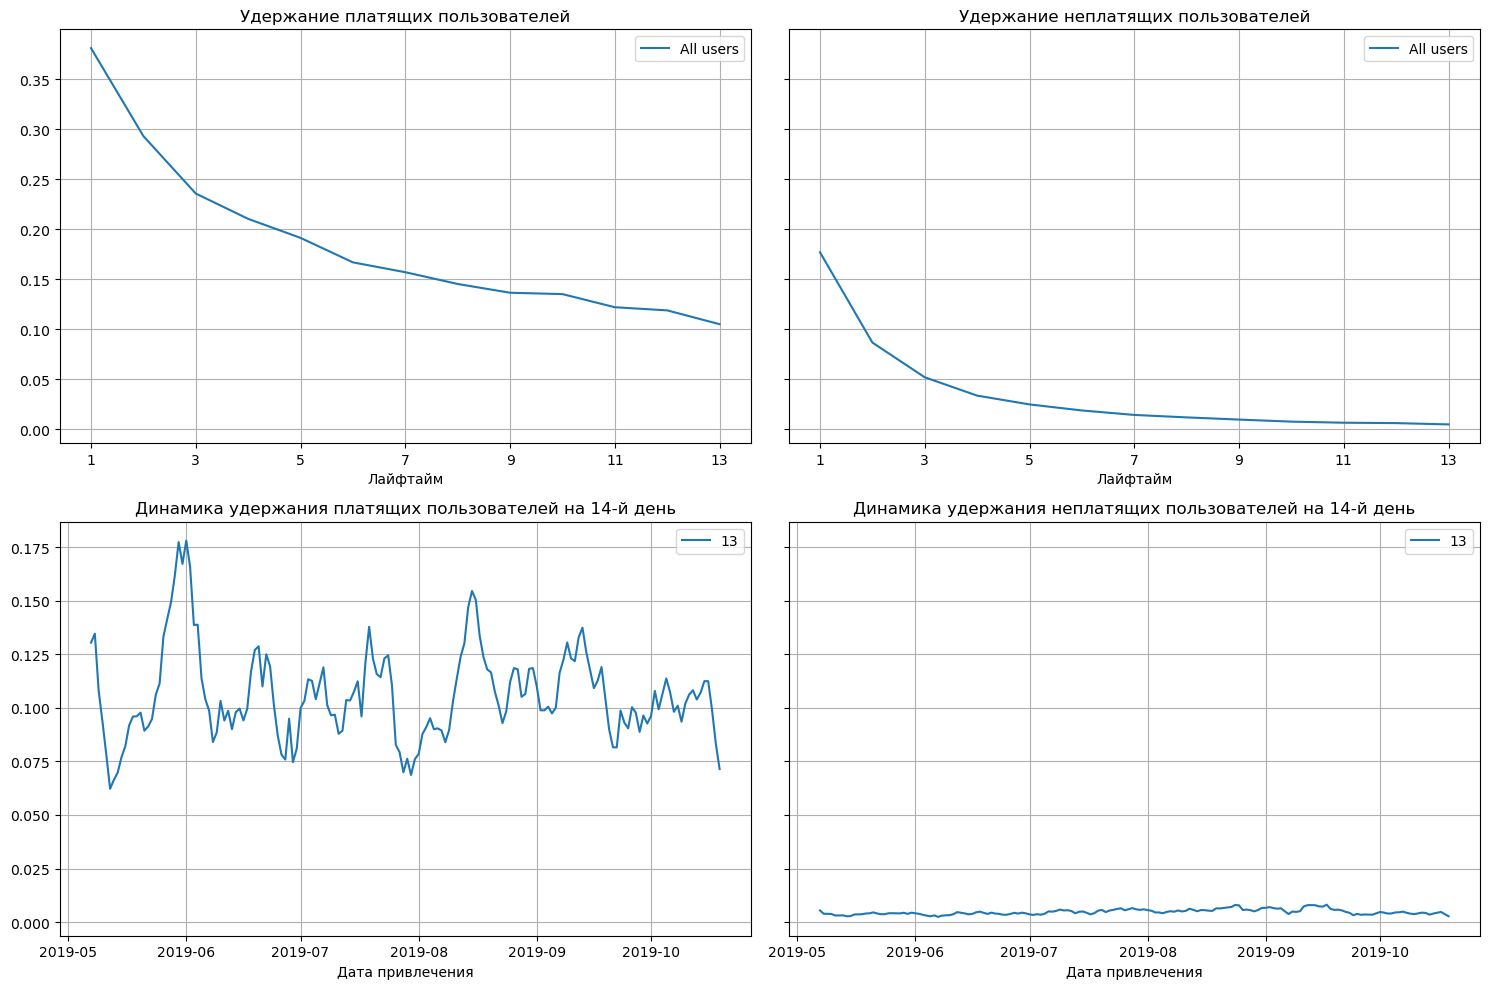

In [36]:
# смотрим общее удержание пользователей

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Динамика удержания от месяца к месяцу на 14й день более менее стабильна и по платящим пользователям и по неплатящим. А вот удержание платящих пользователей достаточно сильно снижается к 14 дню. Здесь лучше посмотреть в разбивке по странам, устройствам и каналам привлечения, возможно там увидим какие-то проблемы. Сделаем это в следующем шаге 5.3.

### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

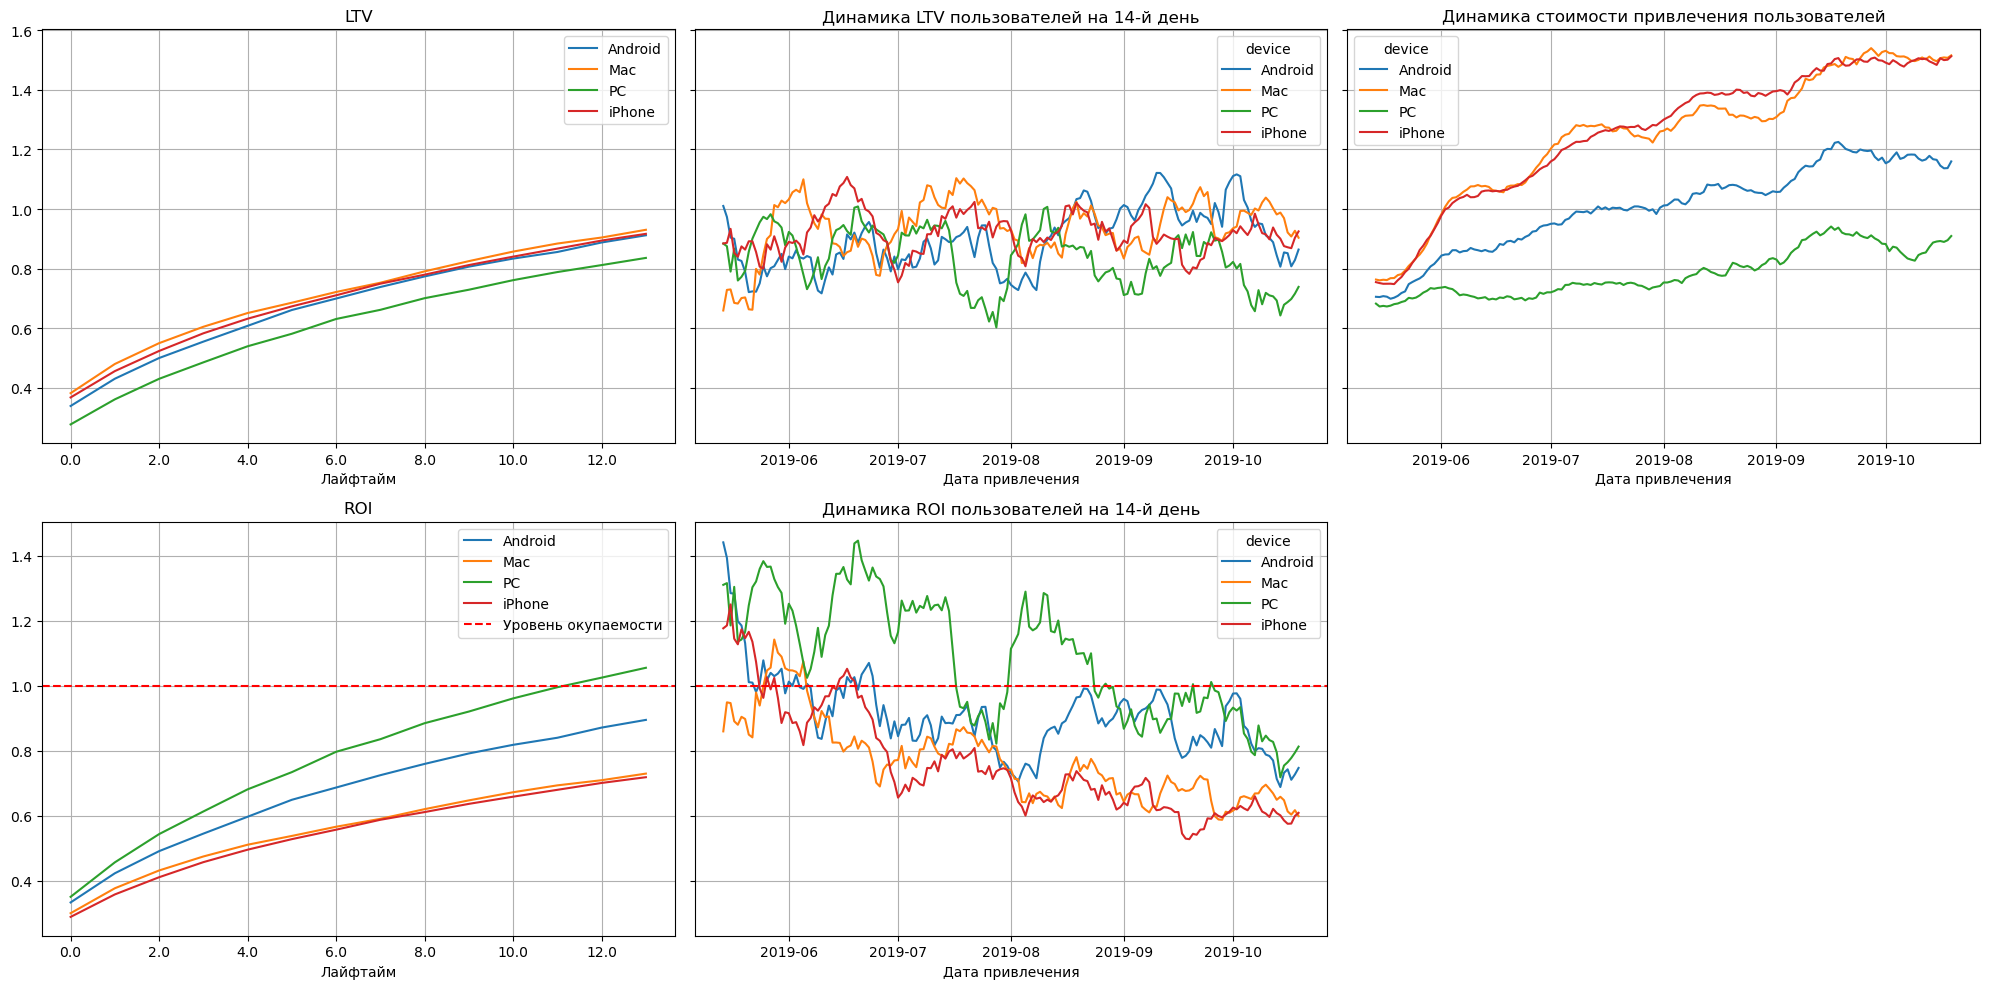

In [37]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Итак, LTV хуже всего у PC, остальные устройства имеют примерно одинаковый уровень LTV. Но при этом, только PC из всех 4х устройств достигло уровня окупаемости (на 11-ый день) и даже немного превысило его (примерно на 5%) - но на это устройство было выделено меньше всего бюджета (см. динамику стоимости привлечения пользоватлей), вероятно, именно поэтому реклама на PC окупилась. Динамика ROI пользователей на 14-ый день по истечению времени снижалась по всем устройствам.

Также посмотрим конверсию и удержание с разбивкой по устройствам.

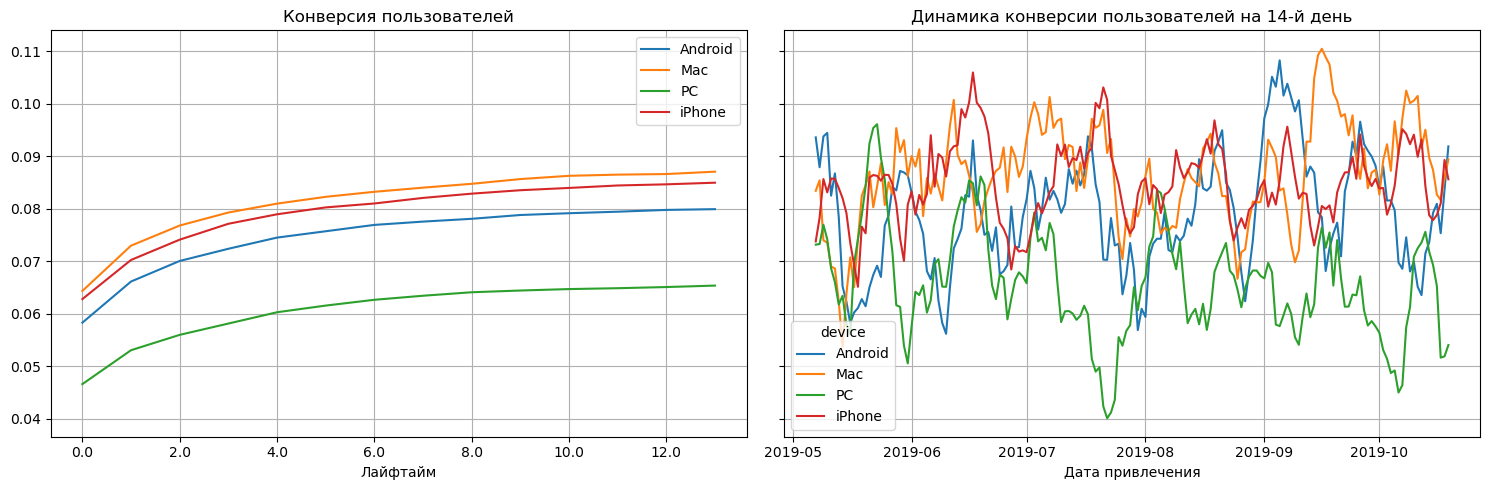

In [38]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Хуже всего конвертировались пользователи PC - Это видно и на общей конверсии, и по динамике конверсии. Самая высокая конверсия - Mac и iPhone.

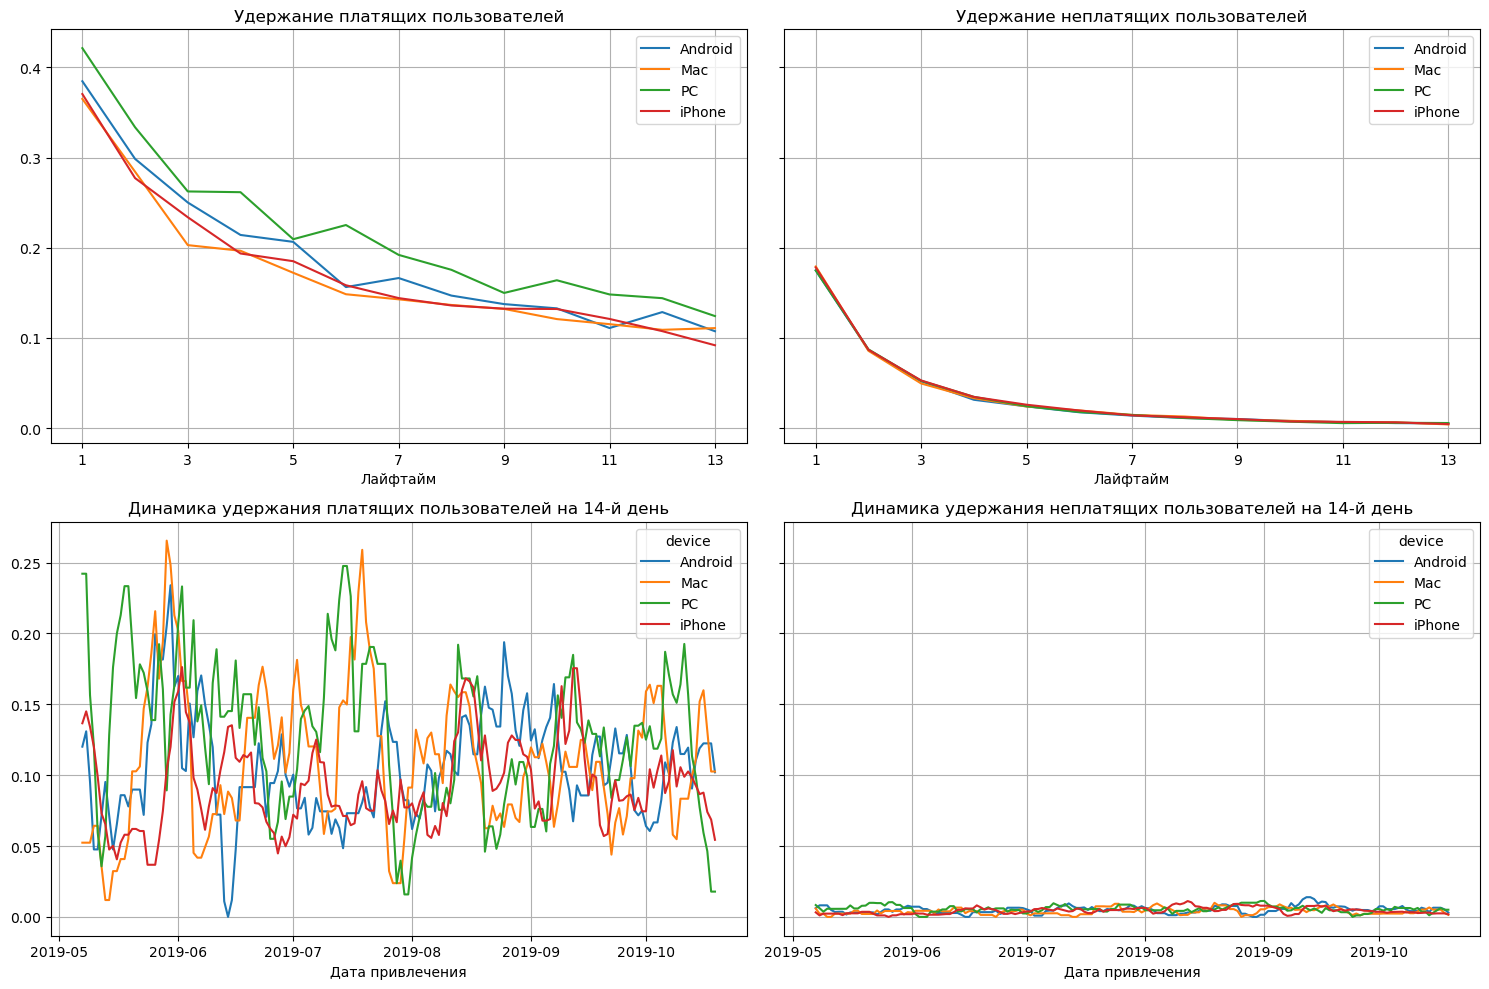

In [39]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

А вот удержание пользователей лучше всего по устройству PC.

Я бы рекомендовала отделу маркетинга подумать об увеличении расходов на рекламу по устройству PC - тогда возможно пользователи будут лучше конвертироваться и приносить бОльшую окупаемость, а вот расходы на рекламу по остальным устройствам необоснованно превышены - их нужно сократить, что возможно принесет окупаемость. 

### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

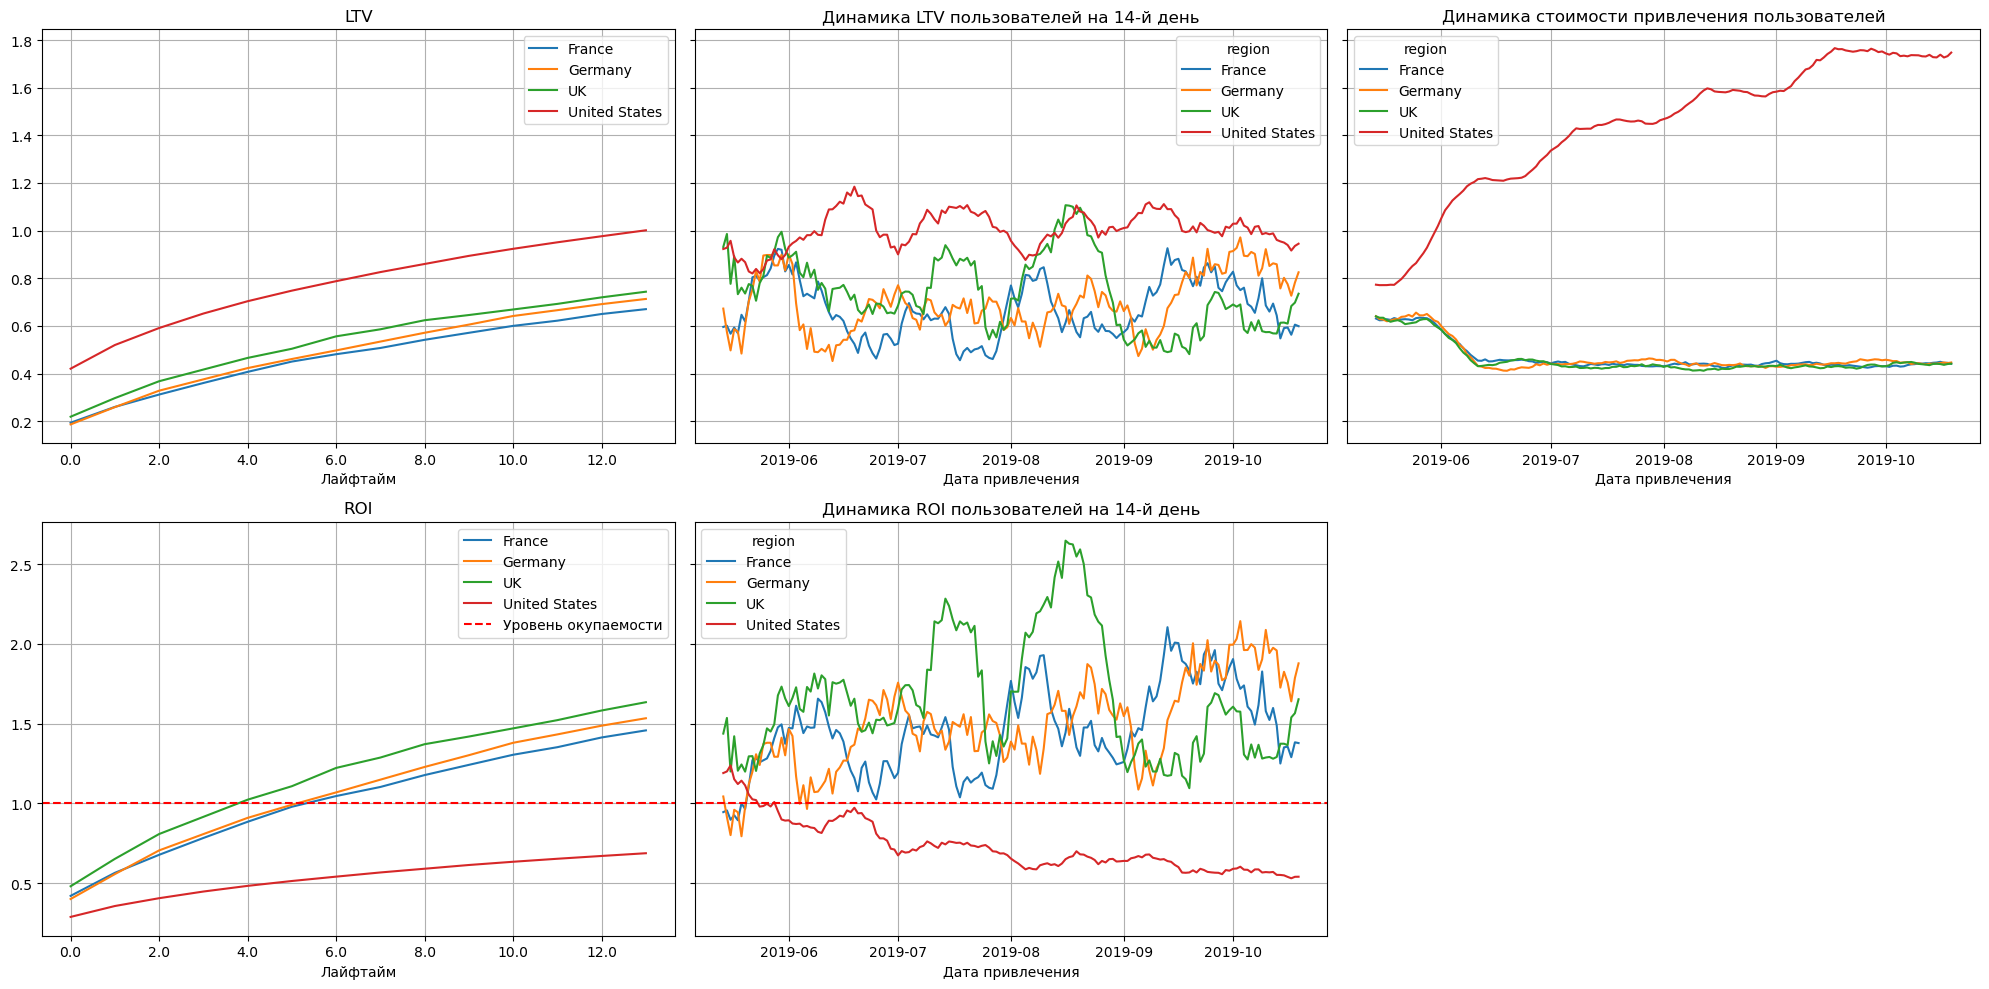

In [40]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Самый высокий LTV у пользователей США. И очень большие расходы на привлечение пользователей из США - и как следствие, нет окупаемости совсем. По остальным странам примерно одинаковый LTV, траты на привлечение (без увеличения от месяца к месяцу) - и вот он хороший результат - уже на 5ый и 6ой дни реклама окупается и конвертируется в реальный доход и достигает 50-60% от расходов на рекламу. Расходы на рекламу для пользователей США необоснованно велики - нужно дать рекомендации отделу маркетинга снизить их, они несут убытки.

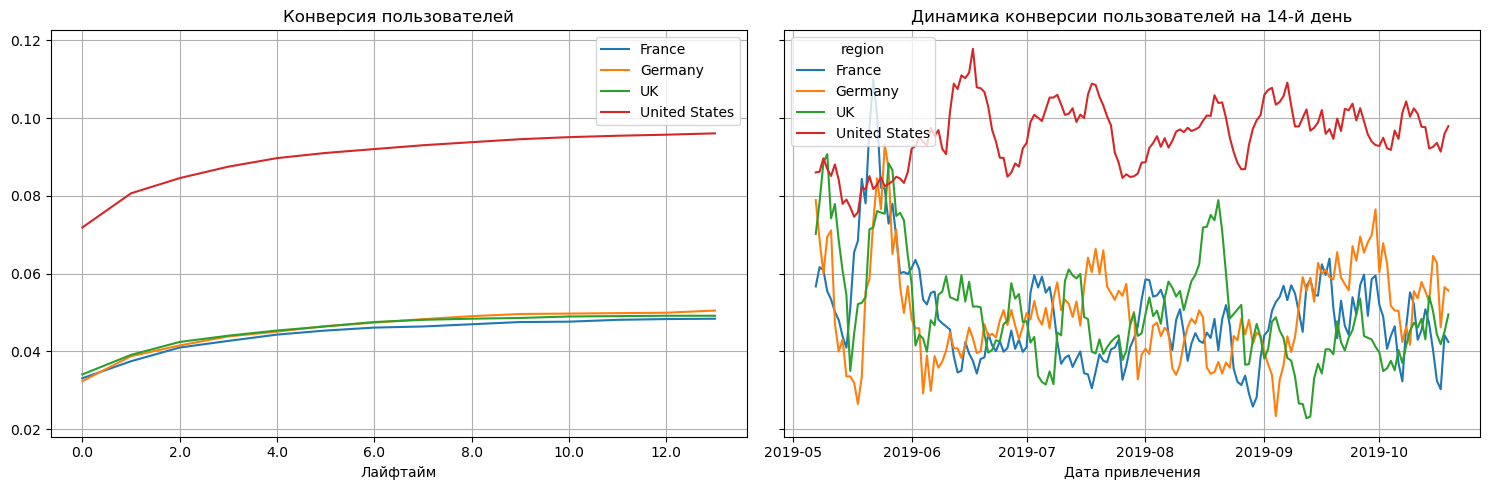

In [41]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Логично, такая высокая конверсия по США, вероятно, является следствием больших трат на привлечение пользователей из США.

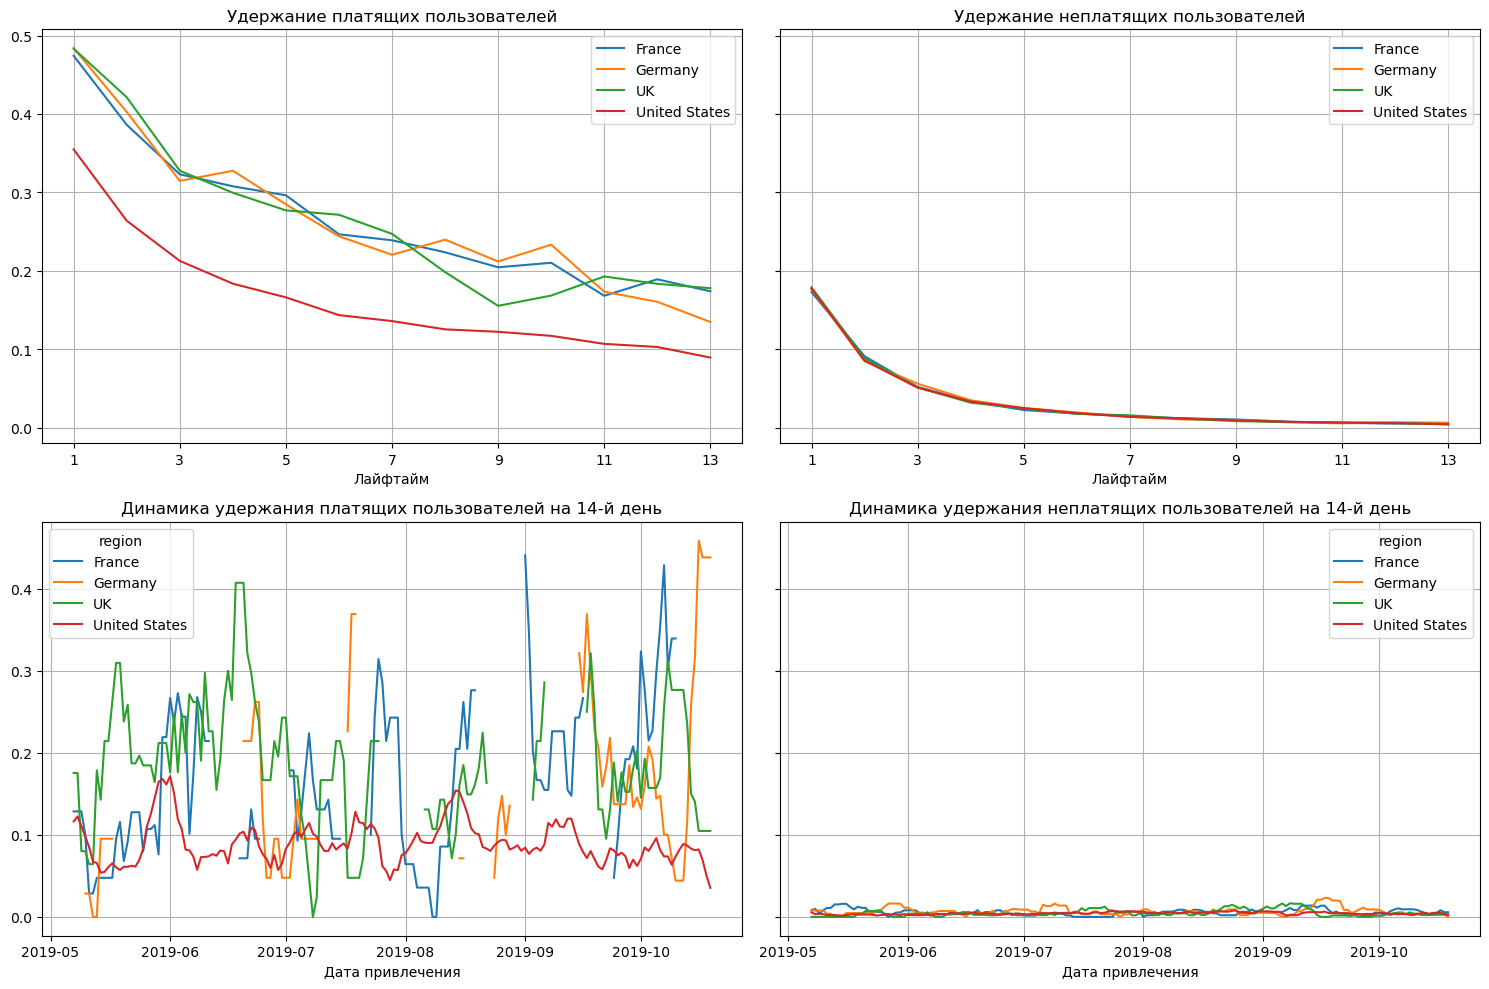

In [42]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Еще одна проблема в США: пользователи, которые итак дорого обходятся, еще и стабильно плохо удерживаются - на 14ый день удержание составляет менее 10 %, тогда как остальные страны имеют удержание примерно от 14 до 18 %. Возможно есть какие-то технические проблемы по стране привлечения США.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

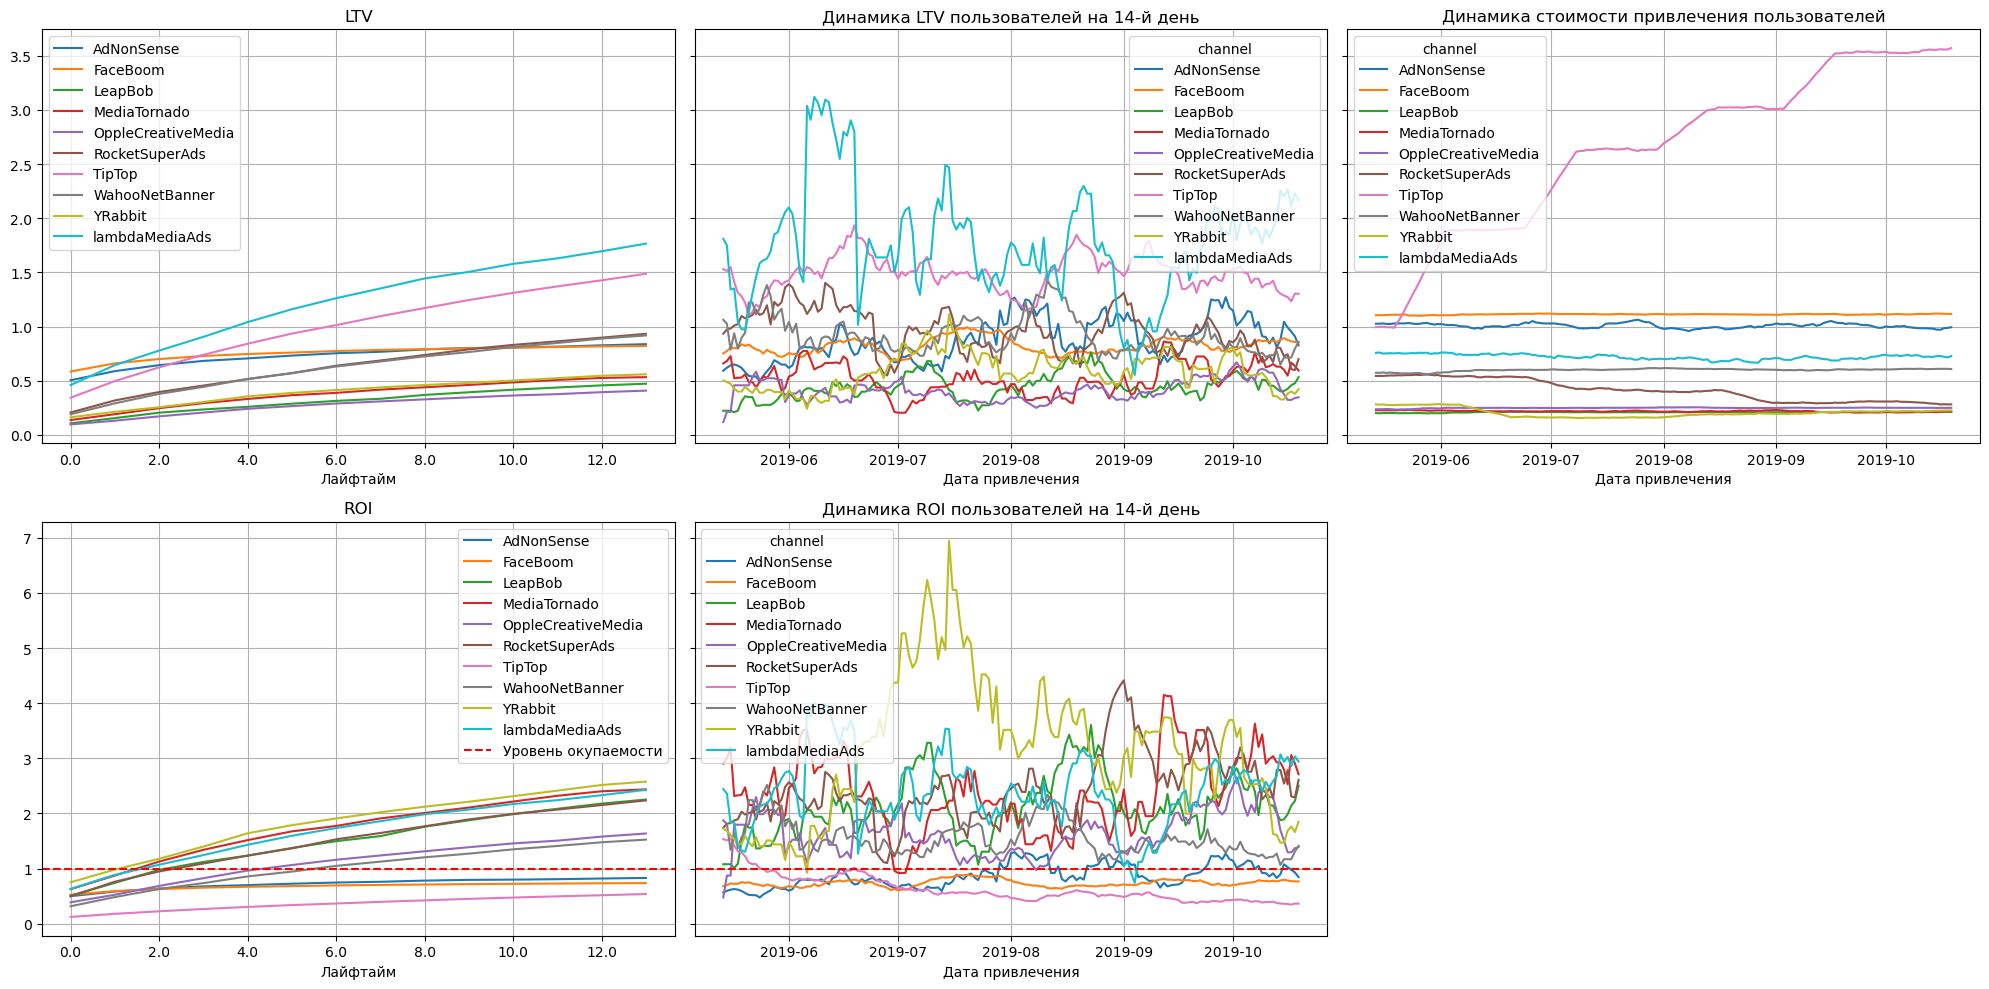

In [43]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По каким-то причинам маркетологи потратили на канал TipTop средств в несколько раз больше, чем на все другие каналы, и постоянно увеличивали эти расходы от месяца к месяцу. Да, LTV вышел хороший у TipTop, но при этом он совершенно не окупается, даже на 14ый день. Нужно дать рекомендацию обратить внимание на это, и уменьшить расходы на рекламу по каналу TipTop. Самые хорошие показатели, сбалансированные, дает канал lambdaMediaAds - самый высокий LTV, средние расходы на рекламу, прекрасная окупаемость - до 150% от трат на рекламу! Также не приносят окупаемости еще 2 канала ADNoneSense и FaceBoom. И нужно отметить всплеск на графике динамики ROI по каналу YRabbit в период июль-август - то есть в этот период реклама по этому каналу очень хорошо сработала.

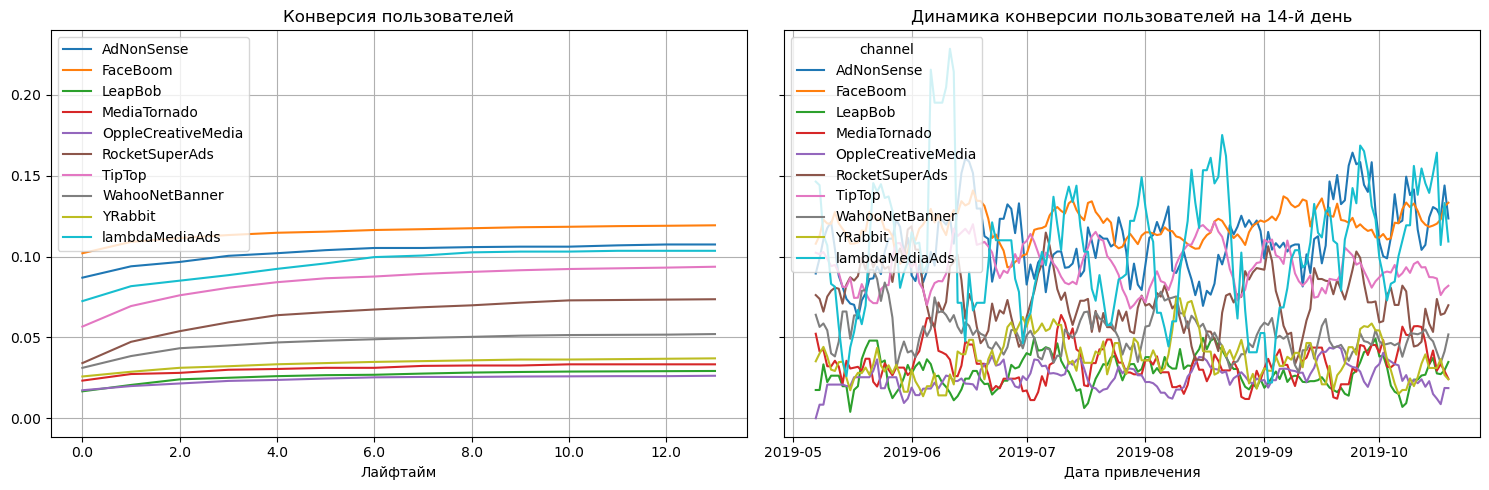

In [44]:
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

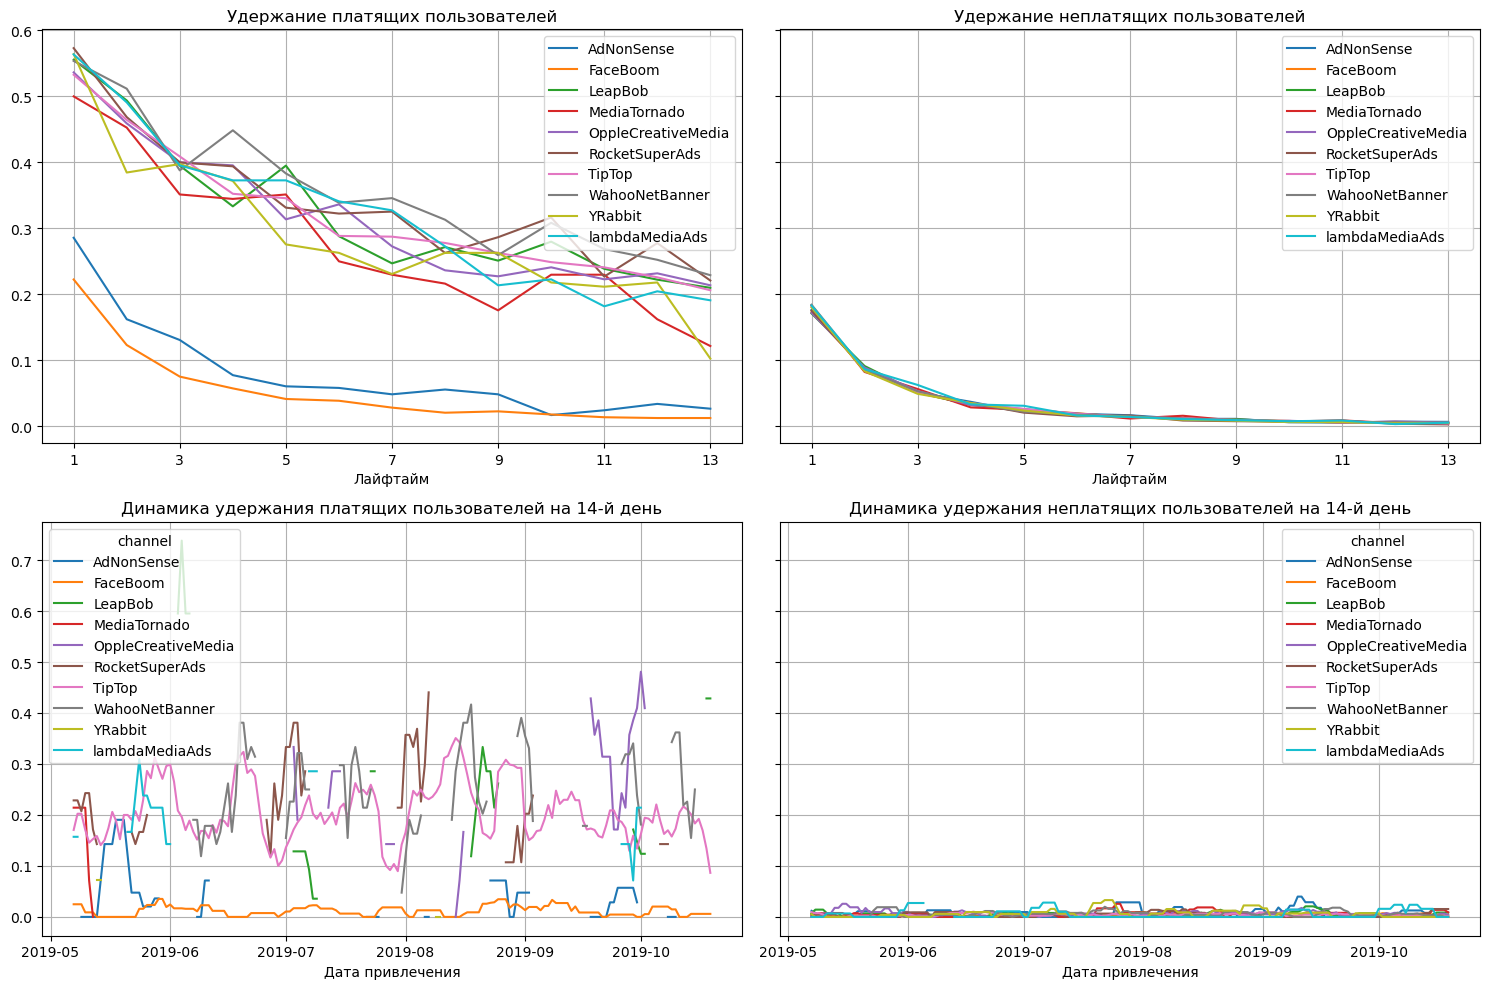

In [45]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По конверсии FaceBoom и AdNonSense лидируют, при этом по удержанию есть проблема - пользователи уходят из приложения в бóльших масштабах, чем ожидается. Новые пользователи, пришедшие из этих каналов, слабо конвертируются в постоянных клиентов. TipTop, отличающийся дорогой рекламой, по удержанию не выделяется на общем фоне. 
    
Качество аудитории в разных каналах различается. Может играть роль и фактор самого канала, в какой момент и как именно он цепляет внимание пользователя. Чтобы улучшить метрики в целом, важно развивать те каналы, которые позволяют эффективнее доносить ценность продукта. 

**Итак,** по шагу 5 построены графики LTV, CAC, ROI, а также конверсии и удержания общие и с разбивкой по устройствам, странам, каналам привлечения. проведен анализ причин неокупаемости рекламы и даны рекомендации отделу маректинга.

## Выводы по работе

Итак, в данной работе был проведен маркетинговый анализ развлекательного приложения Procrastinate Pro+. Были выполнены следующие действия:
* проведена предобработка данных
* заданы функции для расчета и анализа LTV, ROI, удержания и конверсии
* проведен исследовательский и маркетинговый анализ данных
* проведена оценка окупаемости рекламы

А также были построены графики с основными маркетинговыми метриками и выяснены причины убытков компании.

**Причины неэффективности привлечения пользователей** состоят в несбалансированных расходах на рекламу по некоторым странам, устройствам и каналам привлечения, а также возможно в технических проблемах. 

**Рекомендации для отдела маркетинга** 
* Окупаемость рекламы по устройствам: окупаемость рекламы по устройствам очень низкая. Я бы рекомендовала отделу маркетинга подумать об увеличении расходов на рекламу по устройству PC - тогда возможно пользователи будут лучше конвертироваться и приносить бОльшую окупаемость, а вот расходы на рекламу по остальным устройствам необоснованно превышены - их нужно сократить, что возможно принесет окупаемость.
* Окупаемость рекламы по странам: Самый высокий LTV у пользователей США. И очень большие расходы на привлечение пользователей из США - и как следствие, нет окупаемости совсем. По остальным странам примерно одинаковый LTV, траты на привлечение (без увеличения от месяца к месяцу) - и вот он хороший результат - уже на 5ый и 6ой дни реклама окупается и конвертируется в реальный доход и достигает 50-60% от расходов на рекламу. Расходы на рекламу для пользователей США необоснованно велики - нужно дать рекомендации отделу маркетинга снизить их, они несут убытки.Еще одна проблема в США: пользователи, которые итак дорого обходятся, еще и стабильно плохо удерживаются - на 14ый день удержание составляет менее 10 %, тогда как остальные страны имеют удержание примерно от 14 до 18 %. Возможно есть какие-то технические проблемы по стране привлечения США.
* Окупаемость рекламы по каналам привлечения: По каким-то причинам маркетологи потратили на канал TipTop средств в несколько раз больше, чем на все другие каналы, и постоянно увеличивали эти расходы от месяца к месяцу. Да, LTV вышел хороший у TipTop, но при этом он совершенно не окупается, даже на 14ый день. Нужно дать рекомендацию обратить внимание на это, и уменьшить расходы на рекламу по каналу TipTop. Самые хорошие показатели, сбалансированные, дает канал lambdaMediaAds - самый высокий LTV, средние расходы на рекламу, прекрасная окупаемость - до 150% от трат на рекламу!По конверсии FaceBoom и AdNonSense лидируют, при этом по удержанию есть проблема - пользователи уходят из приложения в бóльших масштабах, чем ожидается. Новые пользователи, пришедшие из этих каналов, слабо конвертируются в постоянных клиентов. TipTop, отличающийся дорогой рекламой, по удержанию не выделяется на общем фоне. Качество аудитории в разных каналах различается. Может играть роль и фактор самого канала, в какой момент и как именно он цепляет внимание пользователя. Чтобы улучшить метрики в целом, важно развивать те каналы, которые позволяют эффективнее доносить ценность продукта. 
* Можно порекомендовать каналы для дальнейшего привлечения: lambdaMediaAds, как самый сбалансированный по проведенной рекламной компании. Также можно отметить канал YRabbit - особенно, в период июль-август реклама по этому каналу очень хорошо сработала (что видно по графику динамики ROI). Канал RocketSuperAds имеет средний хороший стаблильный LTV  и хорошую окупаемость.*

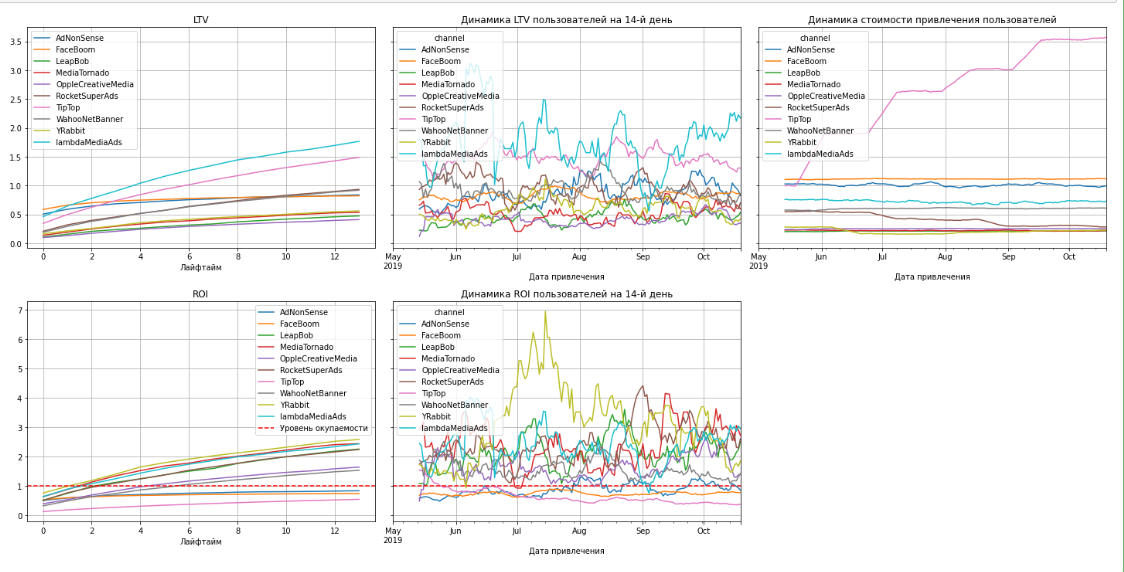